# Pretrained models results

## Packages and Subsidiary Functions

In [ ]:
!pip install pytorch-lightning
!pip install -q pytorch-metric-learning
!pip install facenet-pytorch
!pip install faiss-gpu
!pip install numpy==1.16.2

  Using cached https://files.pythonhosted.org/packages/63/97/af8a92864a04bfa48f1b5c9b1f8bf2ccb2847f24530026f26dd223de4ca0/numpy-1.19.2-cp36-cp36m-manylinux2010_x86_64.whl
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.2
    Uninstalling numpy-1.16.2:
      Successfully uninstalled numpy-1.16.2


  Using cached https://files.pythonhosted.org/packages/35/d5/4f8410ac303e690144f0a0603c4b8fd3b986feb2749c435f7cdbb288f17e/numpy-1.16.2-cp36-cp36m-manylinux1_x86_64.whl
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.16.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.
ERROR: pytorch-lightning 0.9.0 has requirement numpy>=1.16.4, but you'll have numpy 1.16.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2


In [ ]:
import gdown
from google.colab import drive
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, models
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, Resize, RandomHorizontalFlip, RandomErasing
from pytorch_metric_learning import samplers, miners, losses, regularizers
import tensorboard
import pytorch_lightning as pl
import numpy as np
import json
from pytorch_lightning.callbacks import ModelCheckpoint
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
from google.colab import drive
from tqdm import tqdm 
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import time

In [ ]:
!nvidia-smi
from psutil import virtual_memory
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(virtual_memory().total / 1e9))

Fri Sep 25 21:39:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert isinstance(device, torch.device)
print('Running on: {}'.format(device))

Running on: cuda


Functions definitions for evaluation metrices.

In [ ]:
def collate_fn(x):
    return x[0]

In [ ]:
import numpy as np
from sklearn.model_selection import KFold

def evaluate(distances, labels,  dists, thresholds_roc_start = 0.1,thresholds_roc_end =1.5,thresholds_roc_step = 0.1, diagonal_excl=True):
    # Calculate evaluation metrics
    thresholds = np.arange(thresholds_roc_start ,thresholds_roc_end ,thresholds_roc_step)
    tpr, fpr, accuracy, best_threshold_index = calculate_roc(thresholds, distances,labels, dists, diagonal_excl)
    plot_roc(fpr, tpr, figure_name="roc.png")
    print('the best accuracy:',  accuracy[best_threshold_index]  ,'True Positive rate:',  tpr[best_threshold_index] ,'False Positive rate:', fpr[best_threshold_index],'threshold:',thresholds[best_threshold_index])
   

def calculate_roc(thresholds, distances, labels, dists, diagonal_excl): 
    nrof_pairs = min(len(labels), len(distances))
    nrof_thresholds = len(thresholds)
    
    tprs = np.zeros((nrof_thresholds))
    fprs = np.zeros((nrof_thresholds))
    
    
    acc = np.zeros((nrof_thresholds))

    for threshold_idx, threshold in enumerate(thresholds):
       tprs[threshold_idx], fprs[threshold_idx], acc[threshold_idx] = calculate_accuracy(threshold, distances, dists, labels,diagonal_excl)
    best_threshold_index = np.argmax(acc)

    return tprs, fprs, acc , best_threshold_index

def calculate_accuracy(threshold, dist, dists, actual_issame, diagonal_excl):
    predict_issame = np.less(dist, threshold)
    if diagonal_excl==True:
      tp = np.sum(np.logical_and(predict_issame, actual_issame))-len(dists)
    else: 
      tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    if diagonal_excl==True:
      acc = float(tp + tn) / (dist.size-len(dists))
    else:  acc = float(tp + tn) / dist.size
    return tpr, fpr, acc


def plot_roc(fpr, tpr, figure_name="roc.png"):
    import matplotlib.pyplot as plt
    plt.switch_backend('Agg')

    from sklearn.metrics import auc
    roc_auc = auc(fpr, tpr)
    fig = plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='#16a085',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='#2c3e50', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", frameon=False)
    fig.savefig(figure_name, dpi=fig.dpi)

In [ ]:
def calculate_accuracy_s(threshold, dist, dists, actual_issame): # accuracy - delete dist=0
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))-len(dists)#hd
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    acc = float(tp + tn) / ((len(dist)*len(dist[0]))-len(dists)) #acc = float(tp + tn) / dist.size
    return tp,fp,tn,fn,tpr, fpr, acc

## Datasets downloading and praparation for models training

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### VGGFace2 sample data for MobileFaceNet model training

In [ ]:
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_1_aligned_mobile.zip' '/content'
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_2_aligned_mobile.zip' '/content'
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_3_aligned_mobile.zip' '/content'
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_4_aligned_mobile.zip' '/content'
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_5_aligned_mobile.zip' '/content'

In [ ]:
!unzip train_1_aligned_mobile.zip
!unzip train_2_aligned_mobile.zip
!unzip train_3_aligned_mobile.zip
!unzip train_4_aligned_mobile.zip
!unzip train_5_aligned_mobile.zip

!rm train_1_aligned_mobile.zip
!rm train_2_aligned_mobile.zip
!rm train_3_aligned_mobile.zip
!rm train_4_aligned_mobile.zip
!rm train_5_aligned_mobile.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: content/train_5_aligned/n002461/0263_01.jpg  
  inflating: content/train_5_aligned/n002461/0082_01.jpg  
  inflating: content/train_5_aligned/n002461/0372_01.jpg  
  inflating: content/train_5_aligned/n002461/0134_01.jpg  
  inflating: content/train_5_aligned/n002461/0242_01.jpg  
  inflating: content/train_5_aligned/n002461/0119_01.jpg  
  inflating: content/train_5_aligned/n002461/0088_01.jpg  
  inflating: content/train_5_aligned/n002461/0198_01.jpg  
  inflating: content/train_5_aligned/n002461/0282_01.jpg  
  inflating: content/train_5_aligned/n002461/0289_01.jpg  
  inflating: content/train_5_aligned/n002461/0083_01.jpg  
  inflating: content/train_5_aligned/n002461/0231_01.jpg  
  inflating: content/train_5_aligned/n002461/0208_03.jpg  
  inflating: content/train_5_aligned/n002461/0317_01.jpg  
  inflating: content/train_5_aligned/n002461/0125_01.jpg  
  inflating: content/train_5_aligned/n002461/0240_

In [ ]:
!mkdir '/content/vgg2_train'
!mkdir '/content/vgg2_test'

%cp -r /content/content/train_1_aligned/* '/content/vgg2_train'
%cp -r /content/content/train_2_aligned/* '/content/vgg2_train'
%cp -r /content/content/train_3_aligned/* '/content/vgg2_train'
%cp -r /content/content/train_4_aligned/* '/content/vgg2_train'

%cp -r /content/content/train_5_aligned/* '/content/vgg2_test'

### Personal Photos

In [ ]:
url = ###
output = 'faces_folder.zip'
gdown.download(url, output, False)
!unzip -o faces_folder.zip
!rm faces_folder.zip

Downloading...
From: https://drive.google.com/uc?export=download&id=1zmRmId5xFU4MRrDZ9j5EgYv5bhFlv1nM
To: /content/faces_folder.zip
124MB [00:00, 236MB/s] 


Archive:  faces_folder.zip
   creating: Faces_Folder/
   creating: Faces_Folder/DD/
  inflating: Faces_Folder/DD/DD_100_143.jpg  
  inflating: Faces_Folder/DD/DD_100_4850.jpg  
  inflating: Faces_Folder/DD/DD_100_600.jpg  
  inflating: Faces_Folder/DD/DD_100_7510.jpg  
  inflating: Faces_Folder/DD/DD_100_4711.jpg  
  inflating: Faces_Folder/DD/DD_100_1410.jpg  
  inflating: Faces_Folder/DD/DD_100_6550.jpg  
  inflating: Faces_Folder/DD/DD_100_6050.jpg  
  inflating: Faces_Folder/DD/DD_100_1371.jpg  
  inflating: Faces_Folder/DD/DD_100_6570.jpg  
  inflating: Faces_Folder/DD/DD_100_5170.jpg  
  inflating: Faces_Folder/DD/DD_100_1841.jpg  
  inflating: Faces_Folder/DD/DD_100_7250.jpg  
  inflating: Faces_Folder/DD/DD_100_2720.jpg  
  inflating: Faces_Folder/DD/DD_100_3050.jpg  
  inflating: Faces_Folder/DD/DD_100_6590.jpg  
  inflating: Faces_Folder/DD/DD_100_7550.jpg  
  inflating: Faces_Folder/DD/DD_100_4360.jpg  
  inflating: Faces_Folder/DD/DD_100_8900.jpg  
  inflating: Faces_Folder

### LFW

In [ ]:
url = 'https://drive.google.com/uc?id=1vfjmbep7UtbY76j81T0jcF4ePbTw-oMY'
output = 'lfw.tgz'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/uc?id=1vfjmbep7UtbY76j81T0jcF4ePbTw-oMY
To: /content/lfw.tgz
181MB [00:02, 60.9MB/s]


'lfw.tgz'

In [ ]:
import tarfile
tar = tarfile.open('lfw.tgz')
tar.extractall()
tar.close()

## Models

In [ ]:
'''
    implement Light CNN
    @author: Alfred Xiang Wu
    @date: 2017.07.04
'''

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class mfm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, type=1):
        super(mfm, self).__init__()
        self.out_channels = out_channels
        if type == 1:
            self.filter = nn.Conv2d(in_channels, 2*out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        else:
            self.filter = nn.Linear(in_channels, 2*out_channels)

    def forward(self, x):
        x = self.filter(x)
        out = torch.split(x, self.out_channels, 1)
        return torch.max(out[0], out[1])

class group(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(group, self).__init__()
        self.conv_a = mfm(in_channels, in_channels, 1, 1, 0)
        self.conv   = mfm(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        x = self.conv_a(x)
        x = self.conv(x)
        return x

class resblock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(resblock, self).__init__()
        self.conv1 = mfm(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = mfm(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        res = x
        out = self.conv1(x)
        out = self.conv2(out)
        out = out + res
        return out

class network_9layers(nn.Module):
    def __init__(self, num_classes=79077):
        super(network_9layers, self).__init__()
        self.features = nn.Sequential(
            mfm(1, 48, 5, 1, 2), 
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True), 
            group(48, 96, 3, 1, 1), 
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            group(96, 192, 3, 1, 1),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True), 
            group(192, 128, 3, 1, 1),
            group(128, 128, 3, 1, 1),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            )
        self.fc1 = mfm(8*8*128, 256, type=0)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.dropout(x, training=self.training)
        out = self.fc2(x)
        return out #, x

class network_29layers(nn.Module):
    def __init__(self, block, layers, num_classes=79077):
        super(network_29layers, self).__init__()
        self.conv1  = mfm(1, 48, 5, 1, 2)
        self.pool1  = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.block1 = self._make_layer(block, layers[0], 48, 48)
        self.group1 = group(48, 96, 3, 1, 1)
        self.pool2  = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.block2 = self._make_layer(block, layers[1], 96, 96)
        self.group2 = group(96, 192, 3, 1, 1)
        self.pool3  = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.block3 = self._make_layer(block, layers[2], 192, 192)
        self.group3 = group(192, 128, 3, 1, 1)
        self.block4 = self._make_layer(block, layers[3], 128, 128)
        self.group4 = group(128, 128, 3, 1, 1)
        self.pool4  = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.fc     = mfm(8*8*128, 256, type=0)
        self.fc2    = nn.Linear(256, num_classes)
            
    def _make_layer(self, block, num_blocks, in_channels, out_channels):
        layers = []
        for i in range(0, num_blocks):
            layers.append(block(in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)

        x = self.block1(x)
        x = self.group1(x)
        x = self.pool2(x)

        x = self.block2(x)
        x = self.group2(x)
        x = self.pool3(x)

        x = self.block3(x)
        x = self.group3(x)
        x = self.block4(x)
        x = self.group4(x)
        x = self.pool4(x)

        x = x.view(x.size(0), -1)
        fc = self.fc(x)
        fc = F.dropout(fc, training=self.training)
        out = self.fc2(fc)
        return out #, fc


class network_29layers_v2(nn.Module):
    def __init__(self, block, layers, num_classes=79077):
        super(network_29layers_v2, self).__init__()
        self.conv1    = mfm(1, 48, 5, 1, 2)
        self.block1   = self._make_layer(block, layers[0], 48, 48)
        self.group1   = group(48, 96, 3, 1, 1)
        self.block2   = self._make_layer(block, layers[1], 96, 96)
        self.group2   = group(96, 192, 3, 1, 1)
        self.block3   = self._make_layer(block, layers[2], 192, 192)
        self.group3   = group(192, 128, 3, 1, 1)
        self.block4   = self._make_layer(block, layers[3], 128, 128)
        self.group4   = group(128, 128, 3, 1, 1)
        self.fc       = nn.Linear(8*8*128, 256)
        self.fc2 = nn.Linear(256, num_classes, bias=False)
            
    def _make_layer(self, block, num_blocks, in_channels, out_channels):
        layers = []
        for i in range(0, num_blocks):
            layers.append(block(in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2) + F.avg_pool2d(x, 2)

        x = self.block1(x)
        x = self.group1(x)
        x = F.max_pool2d(x, 2) + F.avg_pool2d(x, 2)

        x = self.block2(x)
        x = self.group2(x)
        x = F.max_pool2d(x, 2) + F.avg_pool2d(x, 2)

        x = self.block3(x)
        x = self.group3(x)
        x = self.block4(x)
        x = self.group4(x)
        x = F.max_pool2d(x, 2) + F.avg_pool2d(x, 2)

        x = x.view(x.size(0), -1)
        fc = self.fc(x)
        x = F.dropout(fc, training=self.training)
        out = self.fc2(x)
        return out #, fc

def LightCNN_9Layers(**kwargs):
    model = network_9layers(**kwargs)
    return model

def LightCNN_29Layers(**kwargs):
    model = network_29layers(resblock, [1, 2, 3, 4], **kwargs)
    return model

def LightCNN_29Layers_v2(**kwargs):
    model = network_29layers_v2(resblock, [1, 2, 3, 4], **kwargs)
    return model

### LightCNN 9

Model downlading.

In [ ]:
lightcnn9 = LightCNN_9Layers()

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1AbnUIzh_mp96MTQA4JSKjZDIMHdaCR9u'
output = 'LightCNN_9Layers_checkpoint.pth'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1AbnUIzh_mp96MTQA4JSKjZDIMHdaCR9u
To: /content/LightCNN_9Layers_checkpoint.pth
206MB [00:01, 153MB/s]


'LightCNN_9Layers_checkpoint.pth'

In [ ]:
for name, _ in lightcnn9.named_parameters():
  print(name)

features.0.filter.weight
features.0.filter.bias
features.2.conv_a.filter.weight
features.2.conv_a.filter.bias
features.2.conv.filter.weight
features.2.conv.filter.bias
features.4.conv_a.filter.weight
features.4.conv_a.filter.bias
features.4.conv.filter.weight
features.4.conv.filter.bias
features.6.conv_a.filter.weight
features.6.conv_a.filter.bias
features.6.conv.filter.weight
features.6.conv.filter.bias
features.7.conv_a.filter.weight
features.7.conv_a.filter.bias
features.7.conv.filter.weight
features.7.conv.filter.bias
fc1.filter.weight
fc1.filter.bias
fc2.weight
fc2.bias


In [ ]:
lightcnn9

network_9layers(
  (features): Sequential(
    (0): mfm(
      (filter): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): group(
      (conv_a): mfm(
        (filter): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): group(
      (conv_a): mfm(
        (filter): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(96, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (6): group(
      (conv_a): mfm(
        (filter): Conv2d(192, 384, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (f

In [ ]:
load_dict = torch.load('/content/LightCNN_9Layers_checkpoint.pth')
state_dict = load_dict['state_dict']

In [ ]:
for name, _ in state_dict.items():
  print(name)

module.features.0.filter.weight
module.features.0.filter.bias
module.features.2.conv_a.filter.weight
module.features.2.conv_a.filter.bias
module.features.2.conv.filter.weight
module.features.2.conv.filter.bias
module.features.4.conv_a.filter.weight
module.features.4.conv_a.filter.bias
module.features.4.conv.filter.weight
module.features.4.conv.filter.bias
module.features.6.conv_a.filter.weight
module.features.6.conv_a.filter.bias
module.features.6.conv.filter.weight
module.features.6.conv.filter.bias
module.features.7.conv_a.filter.weight
module.features.7.conv_a.filter.bias
module.features.7.conv.filter.weight
module.features.7.conv.filter.bias
module.fc1.filter.weight
module.fc1.filter.bias
module.fc2.weight
module.fc2.bias


In [ ]:
new_state_dict = {}
for name, params in state_dict.items():
  new_name = name.replace('module.', '')
  new_state_dict[new_name] = params

In [ ]:
lightcnn9.load_state_dict(new_state_dict)

<All keys matched successfully>

In [ ]:
for name, params in lightcnn9.named_parameters():
  params.requires_grad = False

In [ ]:
lightcnn9.fc2 = nn.Identity()
lightcnn9

network_9layers(
  (features): Sequential(
    (0): mfm(
      (filter): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): group(
      (conv_a): mfm(
        (filter): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): group(
      (conv_a): mfm(
        (filter): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(96, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (6): group(
      (conv_a): mfm(
        (filter): Conv2d(192, 384, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (f

In [ ]:
for i, (name, prams) in enumerate(lightcnn9.named_parameters()):
  print(i, name)

0 features.0.filter.weight
1 features.0.filter.bias
2 features.2.conv_a.filter.weight
3 features.2.conv_a.filter.bias
4 features.2.conv.filter.weight
5 features.2.conv.filter.bias
6 features.4.conv_a.filter.weight
7 features.4.conv_a.filter.bias
8 features.4.conv.filter.weight
9 features.4.conv.filter.bias
10 features.6.conv_a.filter.weight
11 features.6.conv_a.filter.bias
12 features.6.conv.filter.weight
13 features.6.conv.filter.bias
14 features.7.conv_a.filter.weight
15 features.7.conv_a.filter.bias
16 features.7.conv.filter.weight
17 features.7.conv.filter.bias
18 fc1.filter.weight
19 fc1.filter.bias


In [ ]:
for name, params in lightcnn9.named_parameters():
  if params.requires_grad == True:
    print(name)

#### MTCNN for Personal Photos

In [ ]:
data_dir = '/content/Faces_Folder'

Importing MTCNN.

In [ ]:
!git clone https://github.com/TreB1eN/InsightFace_Pytorch.git

fatal: destination path 'InsightFace_Pytorch' already exists and is not an empty directory.


In [ ]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

Aligned images and execution time results.

In [ ]:
time_ = []
aligned_dd = []
names_dd = []
trans = transforms.ToTensor()

for x, y in tqdm(loader):
  start_ = time.time()
  
  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)

    diff = time.time() - start_
    time_.append(diff)

    aligned_dd.append(trans(x_aligned))
    names_dd.append(dataset.idx_to_class[y])

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

  0%|          | 0/1205 [00:00<?, ?it/s]/content/InsightFace_Pytorch/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)
100%|██████████| 1205/1205 [04:35<00:00,  4.37it/s]


Total time(sec): 241.40, Average(sec):0.24, fps:4.11



Number of aligned photos after MTCNN.

In [ ]:
len(names_dd)

991

#### Model validation results on Personal Photos

Calculating elements needed for evaluation metrices calculation.

In [ ]:
dists2_dd = [[e2==e1 for e2 in names_dd] for e1 in tqdm(names_dd)]

100%|██████████| 991/991 [00:00<00:00, 22818.53it/s]


In [ ]:
aligned_dd = torch.stack(tuple(aligned_dd)).to(device)

In [ ]:
dataset = aligned_dd.clone()
batch_size = 1

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [ ]:
data_loader.dataset.size()

torch.Size([991, 3, 112, 112])

In [ ]:
time_ = []

lightcnn9.to(device).eval()
img_transformed = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(num_output_channels=1), transforms.Resize([resize,resize]), transforms.ToTensor()])

output_embeddings = []


for i, image in tqdm(enumerate(data_loader)):
  image = image.cpu()
  image = img_transformed(image.squeeze(0))
  image = image.unsqueeze(0)

  start_ = time.time()

  output = lightcnn9(image.to(device))

  diff = time.time() - start_
  time_.append(diff)

  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))


# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

991it [00:02, 409.71it/s]


Total time(sec): 1.37, Average(sec):0.00, fps:721.68



In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
len(output_embeddings)

991

In [ ]:
dists_dd = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]

100%|██████████| 991/991 [00:13<00:00, 73.51it/s]


In [ ]:
len(dists_dd),len(dists_dd[0]),len(dists2_dd),len(dists2_dd[0])

(991, 991, 991, 991)

In [ ]:
np.array(dists_dd)[0].size

991

the best accuracy: 0.8377131557757188 True Positive rate: 0.6276169630297793 False Positive rate: 0.0619676397238654 threshold: 1.2499999999999996


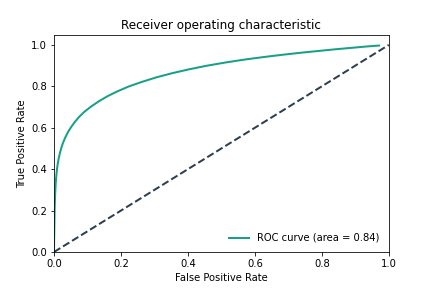

In [ ]:
evaluate(np.array(dists_dd),np.array(dists2_dd), dists_dd,thresholds_roc_start= 0.1, thresholds_roc_end=1.5,thresholds_roc_step=0.01, diagonal_excl=True)
Image.open('/content/roc.png')

#### MTCNN for LFW dataset

In [ ]:
data_dir = '/content/lfw'

MTCNN importing

In [ ]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

Aligned data preparation and execution time results.

In [ ]:
time_ = []
aligned_lfw = []
names_lfw = []
trans = transforms.ToTensor()

for x, y in tqdm(loader):
  start_ = time.time()
  
  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)

    diff = time.time() - start_
    time_.append(diff)

    aligned_lfw.append(trans(x_aligned))
    names_lfw.append(dataset.idx_to_class[y])

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

  0%|          | 0/13233 [00:00<?, ?it/s]/content/InsightFace_Pytorch/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)
100%|██████████| 13233/13233 [09:32<00:00, 23.11it/s]


Total time(sec): 546.65, Average(sec):0.04, fps:23.89



Number of photos after MTCNN application.

In [ ]:
len(names_lfw)

13059

#### Model validation results on LWE dataset

Calculating elements for evaluation metrices calculation.

In [ ]:
labels_lfw = [[e2==e1 for e2 in names_lfw] for e1 in tqdm(names_lfw)]

100%|██████████| 13059/13059 [00:08<00:00, 1585.94it/s]


In [ ]:
len(labels_lfw)

13059

In [ ]:
aligned_lfw = torch.stack(tuple(aligned_lfw)).to(device)

In [ ]:
dataset = aligned_lfw.clone()
batch_size = 1

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [ ]:
data_loader.dataset.size()

torch.Size([13059, 3, 112, 112])

Embedding calculation and time execution results.

In [ ]:
time_ = []

lightcnn9.to(device).eval()
img_transformed = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(num_output_channels=1), transforms.Resize([resize,resize]), transforms.ToTensor()])

output_embeddings = []

for i, image in tqdm(enumerate(data_loader)):
  image = image.cpu()
  image = img_transformed(image.squeeze(0))
  image = image.unsqueeze(0)

  start_ = time.time()

  output = lightcnn9(image.to(device))

  diff = time.time() - start_
  time_.append(diff)

  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))


# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

13059it [00:32, 407.18it/s]


Total time(sec): 18.19, Average(sec):0.00, fps:717.76



In [ ]:
len(output_embeddings)

13059

In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
dists_lfw = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]

100%|██████████| 13059/13059 [42:44<00:00,  5.09it/s]


In [ ]:
len(dists_lfw),len(dists_lfw[0]),len(labels_lfw),len(labels_lfw[0])

(13059, 13059, 13059, 13059)

Calculating validation metrices.

the best accuracy: 0.9994168459928866 True Positive rate: 0.8338712700164504 False Positive rate: 0.00011562876549173758 threshold: 1.07


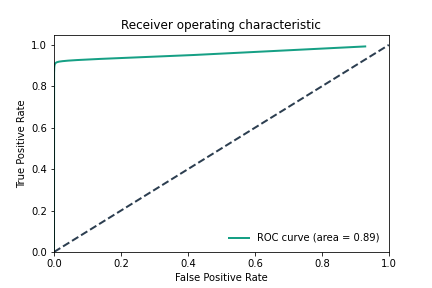

In [ ]:
evaluate(np.array(dists_lfw),np.array(labels_lfw), dists_lfw, thresholds_roc_start= 0.01, thresholds_roc_end=1.5, thresholds_roc_step=0.01, diagonal_excl=True)
Image.open('/content/roc.png')

# Tranfser Learing

## Packages and Subsidiary Functions

In [ ]:
!pip install pytorch-lightning
!pip install -q pytorch-metric-learning
!pip install facenet-pytorch
!pip install faiss-gpu
!pip install numpy==1.16.2

  Using cached https://files.pythonhosted.org/packages/35/d5/4f8410ac303e690144f0a0603c4b8fd3b986feb2749c435f7cdbb288f17e/numpy-1.16.2-cp36-cp36m-manylinux1_x86_64.whl
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.16.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.
ERROR: pytorch-lightning 0.9.0 has requirement numpy>=1.16.4, but you'll have numpy 1.16.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2


In [ ]:
import gdown
from google.colab import drive
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, models
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, Resize, RandomHorizontalFlip, RandomErasing
from pytorch_metric_learning import samplers, miners, losses, regularizers
import tensorboard
import pytorch_lightning as pl
import numpy as np
import json
from pytorch_lightning.callbacks import ModelCheckpoint
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
from google.colab import drive
from tqdm import tqdm 
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import time

In [ ]:
!nvidia-smi
from psutil import virtual_memory
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(virtual_memory().total / 1e9))

Fri Sep 25 21:06:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert isinstance(device, torch.device)
print('Running on: {}'.format(device))

Running on: cuda


##Class definition of Deep Metric Learing.

In [ ]:
class DeepMetricLearner(pl.LightningModule):

    def __init__(self, myclass, net, embedding_size=128, last_layer_size=128, embedding_size_net=128, margin=0.4, batch_size=1024):
        super().__init__()

        self.save_hyperparameters()
        self.embedding_size_net = embedding_size_net
        self.embedding_size = embedding_size
        self.last_layer_size = last_layer_size
        self.batch_size = batch_size
        self.margin = margin
        
        self.net = myclass(net, last_layer_size = self.last_layer_size, embedding_size=self.embedding_size_net)
        self.miner = miners.BatchHardMiner()
        self.loss = losses.TripletMarginLoss(margin=self.margin)

    def forward(self, x):
        return self.net(x.to('cuda')).to('cuda')

    def training_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        triplets = self.miner(embeddings, labels)
        loss = self.loss(embeddings, labels, triplets)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}

    def validation_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        triplets = self.miner(embeddings, labels)
        loss = self.loss(embeddings, labels, triplets)
        return {'val_loss': loss}        

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def prepare_data(self):
      self.train_data = train_data
      self.valid_data = valid_data
      examples_per_class = 2
      self.train_sampler = samplers.MPerClassSampler(labels=self.train_data.idx_to_class, m=examples_per_class, length_before_new_iter=len(self.train_data))
      self.valid_sampler = samplers.MPerClassSampler(labels=self.valid_data.idx_to_class, m=examples_per_class, length_before_new_iter=len(self.valid_data))

    def test_step(self, test_batch, batch_idx):
      pass
    
    def test_epoch_end(self, outputs):
      test_acc_mean = 0
      for output in outputs:
        test_acc_mean += output['acc']

      test_acc_mean /= len(outputs)
      tqdm_dict = {'test_acc': test_acc_mean.item()}

        # show test_loss and test_acc in progress bar but only log test_loss
      results = {
            'progress_bar': tqdm_dict,
            'log': {'test_acc': test_acc_mean.item()}
        }
      return results


    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, sampler=self.train_sampler)

    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size, sampler=self.valid_sampler)
    
    def test_dataloader(self):
        pass

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-4)
        return optimizer


early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
   monitor='val_loss',
   min_delta=0.0,
   patience=2,
   verbose=False,
   mode='min'
)

In [ ]:
class DeepMetricLearnerB(pl.LightningModule):

    def __init__(self, myclass, net, embedding_size=128, last_layer_size=128, embedding_size_net=128, margin=0.4, batch_size=128):
        super().__init__()

        self.save_hyperparameters()
        self.embedding_size_net = embedding_size_net
        self.embedding_size = embedding_size
        self.last_layer_size = last_layer_size
        self.batch_size = batch_size
        self.margin = margin
        

        self.net = myclass(net, last_layer_size = self.last_layer_size, embedding_size=self.embedding_size_net)
        self.distance = distances.CosineSimilarity()#b
        self.reducer = reducers.ThresholdReducer(low = 0)#b
        self.miner =  miners.TripletMarginMiner(margin = 0.2, distance = self.distance, type_of_triplets = "semihard") #b
        self.loss = losses.TripletMarginLoss(margin=self.margin, distance = self.distance, reducer = self.reducer) #b
    
  

    def forward(self, x):
        return self.net(x.to('cuda')).to('cuda')

    def training_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        triplets = self.miner(embeddings, labels)
        loss = self.loss(embeddings, labels, triplets)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}

    def validation_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        triplets = self.miner(embeddings, labels)
        loss = self.loss(embeddings, labels, triplets)
        return {'val_loss': loss}        

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def prepare_data(self):
      self.train_data = train_data
      self.valid_data = valid_data
      examples_per_class = 2
      self.train_sampler = samplers.MPerClassSampler(labels=self.train_data.idx_to_class, m=examples_per_class, length_before_new_iter=len(self.train_data))
      self.valid_sampler = samplers.MPerClassSampler(labels=self.valid_data.idx_to_class, m=examples_per_class, length_before_new_iter=len(self.valid_data))

    def test_step(self, test_batch, batch_idx):
      pass
    
    def test_epoch_end(self, outputs):
      test_acc_mean = 0
      for output in outputs:
        test_acc_mean += output['acc']

      test_acc_mean /= len(outputs)
      tqdm_dict = {'test_acc': test_acc_mean.item()}

        # show test_loss and test_acc in progress bar but only log test_loss
      results = {
            'progress_bar': tqdm_dict,
            'log': {'test_acc': test_acc_mean.item()}
        }
      return results


    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, sampler=self.train_sampler)

    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size, sampler=self.valid_sampler)
    
    def test_dataloader(self):
        pass

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-4)
        return optimizer


early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
   monitor='val_loss',
   min_delta=0.0,
   patience=2,
   verbose=False,
   mode='min'
)

In [ ]:
class DeepMetricLearnerC(pl.LightningModule):

    def __init__(self, myclass, net, embedding_size=128, last_layer_size=128, embedding_size_net=128, margin=0.4, batch_size=1024):
        super().__init__()

        self.save_hyperparameters()
        self.embedding_size_net = embedding_size_net
        self.embedding_size = embedding_size
        self.last_layer_size = last_layer_size
        self.batch_size = batch_size
        self.margin = margin
        
        self.net = myclass(net, last_layer_size = self.last_layer_size, embedding_size=self.embedding_size_net)
        self.miner = miners.BatchHardMiner()
        self.loss = losses.GeneralizedLiftedStructureLoss(neg_margin=1, pos_margin=0)#

    def forward(self, x):
        return self.net(x.to('cuda')).to('cuda')

    def training_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        triplets = self.miner(embeddings, labels)
        loss = self.loss(embeddings, labels, triplets)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}

    def validation_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        triplets = self.miner(embeddings, labels)
        loss = self.loss(embeddings, labels, triplets)
        return {'val_loss': loss}        

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def prepare_data(self):
      self.train_data = train_data
      self.valid_data = valid_data
      examples_per_class = 2
      self.train_sampler = samplers.MPerClassSampler(labels=self.train_data.idx_to_class, m=examples_per_class, length_before_new_iter=len(self.train_data))
      self.valid_sampler = samplers.MPerClassSampler(labels=self.valid_data.idx_to_class, m=examples_per_class, length_before_new_iter=len(self.valid_data))

    def test_step(self, test_batch, batch_idx):
      pass
    
    def test_epoch_end(self, outputs):
      test_acc_mean = 0
      for output in outputs:
        test_acc_mean += output['acc']

      test_acc_mean /= len(outputs)
      tqdm_dict = {'test_acc': test_acc_mean.item()}

        # show test_loss and test_acc in progress bar but only log test_loss
      results = {
            'progress_bar': tqdm_dict,
            'log': {'test_acc': test_acc_mean.item()}
        }
      return results


    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, sampler=self.train_sampler)

    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size, sampler=self.valid_sampler)
    
    def test_dataloader(self):
        pass

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-4)
        return optimizer


early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
   monitor='val_loss',
   min_delta=0.0,
   patience=2,
   verbose=False,
   mode='min'
)

In [ ]:
def set_checkpoint_callback(filepath:str, save_top_k:int, net_name:str):
  
  checkpoint_callback = ModelCheckpoint(
      filepath=os.path.join(filepath,''),
      save_top_k=save_top_k,
      verbose=True,
      monitor='val_loss',
      mode='min',
      prefix=net_name
  )
  return checkpoint_callback

Functions definitions for evaluation metrices.

In [ ]:
def collate_fn(x):
    return x[0]

In [ ]:
import numpy as np
from sklearn.model_selection import KFold

def evaluate(distances, labels,  dists, thresholds_roc_start = 0.1,thresholds_roc_end =1.5,thresholds_roc_step = 0.1, diagonal_excl=True):
    # Calculate evaluation metrics
    thresholds = np.arange(thresholds_roc_start ,thresholds_roc_end ,thresholds_roc_step)
    tpr, fpr, accuracy, best_threshold_index = calculate_roc(thresholds, distances,labels, dists, diagonal_excl)
    plot_roc(fpr, tpr, figure_name="roc.png")
    print('the best accuracy:',  accuracy[best_threshold_index]  ,'True Positive rate:',  tpr[best_threshold_index] ,'False Positive rate:', fpr[best_threshold_index],'threshold:',thresholds[best_threshold_index])
   

def calculate_roc(thresholds, distances, labels, dists, diagonal_excl): 
    nrof_pairs = min(len(labels), len(distances))
    nrof_thresholds = len(thresholds)
    
    tprs = np.zeros((nrof_thresholds))
    fprs = np.zeros((nrof_thresholds))
    
    
    acc = np.zeros((nrof_thresholds))

    for threshold_idx, threshold in enumerate(thresholds):
       tprs[threshold_idx], fprs[threshold_idx], acc[threshold_idx] = calculate_accuracy(threshold, distances, dists, labels,diagonal_excl)
    best_threshold_index = np.argmax(acc)

    return tprs, fprs, acc , best_threshold_index

def calculate_accuracy(threshold, dist, dists, actual_issame, diagonal_excl):
    predict_issame = np.less(dist, threshold)
    if diagonal_excl==True:
      tp = np.sum(np.logical_and(predict_issame, actual_issame))-len(dists)
    else: 
      tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    if diagonal_excl==True:
      acc = float(tp + tn) / (dist.size-len(dists))
    else:  acc = float(tp + tn) / dist.size
    return tpr, fpr, acc


def plot_roc(fpr, tpr, figure_name="roc.png"):
    import matplotlib.pyplot as plt
    plt.switch_backend('Agg')

    from sklearn.metrics import auc
    roc_auc = auc(fpr, tpr)
    fig = plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='#16a085',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='#2c3e50', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", frameon=False)
    fig.savefig(figure_name, dpi=fig.dpi)

In [ ]:
def calculate_accuracy_s(threshold, dist, dists, actual_issame): # accuracy - delete dist=0
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))-len(dists)#hd
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    acc = float(tp + tn) / ((len(dist)*len(dist[0]))-len(dists)) #acc = float(tp + tn) / dist.size
    return tp,fp,tn,fn,tpr, fpr, acc

In [ ]:
# def tensor_to_image(x):

#   transform = Compose([Normalize([0., 0., 0.], [1/0.229, 1/0.224, 1/0.225]),
#                        Normalize([-0.485, -0.456, -0.406], std = [1.,1.,1.]),
#                        ToPILImage()])
#   image = transform(x.cpu())
#   return image

Function for displaying a tensor as an image.


In [ ]:
def display_tensor(x, title=None):
   image = tensor_to_image(x)
   plt.imshow(image)
   if title is not None:
      plt.title('ID osoby: {}'.format(title))

## Datasets downloading and praparation for models training

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### VGGFace2 sample data for MobileFaceNet model training

In [ ]:
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_1_aligned_mobile.zip' '/content'
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_2_aligned_mobile.zip' '/content'
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_3_aligned_mobile.zip' '/content'
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_4_aligned_mobile.zip' '/content'
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_5_aligned_mobile.zip' '/content'

In [ ]:
!unzip train_1_aligned_mobile.zip
!unzip train_2_aligned_mobile.zip
!unzip train_3_aligned_mobile.zip
!unzip train_4_aligned_mobile.zip
!unzip train_5_aligned_mobile.zip

!rm train_1_aligned_mobile.zip
!rm train_2_aligned_mobile.zip
!rm train_3_aligned_mobile.zip
!rm train_4_aligned_mobile.zip
!rm train_5_aligned_mobile.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: content/train_5_aligned/n002461/0263_01.jpg  
  inflating: content/train_5_aligned/n002461/0082_01.jpg  
  inflating: content/train_5_aligned/n002461/0372_01.jpg  
  inflating: content/train_5_aligned/n002461/0134_01.jpg  
  inflating: content/train_5_aligned/n002461/0242_01.jpg  
  inflating: content/train_5_aligned/n002461/0119_01.jpg  
  inflating: content/train_5_aligned/n002461/0088_01.jpg  
  inflating: content/train_5_aligned/n002461/0198_01.jpg  
  inflating: content/train_5_aligned/n002461/0282_01.jpg  
  inflating: content/train_5_aligned/n002461/0289_01.jpg  
  inflating: content/train_5_aligned/n002461/0083_01.jpg  
  inflating: content/train_5_aligned/n002461/0231_01.jpg  
  inflating: content/train_5_aligned/n002461/0208_03.jpg  
  inflating: content/train_5_aligned/n002461/0317_01.jpg  
  inflating: content/train_5_aligned/n002461/0125_01.jpg  
  inflating: content/train_5_aligned/n002461/0240_

In [ ]:
!mkdir '/content/vgg2_train'
!mkdir '/content/vgg2_test'

%cp -r /content/content/train_1_aligned/* '/content/vgg2_train'
%cp -r /content/content/train_2_aligned/* '/content/vgg2_train'
%cp -r /content/content/train_3_aligned/* '/content/vgg2_train'
%cp -r /content/content/train_4_aligned/* '/content/vgg2_train'

%cp -r /content/content/train_5_aligned/* '/content/vgg2_test'

### Personal Photos

In [ ]:
url = ###
output = 'faces_folder.zip'
gdown.download(url, output, False)
!unzip -o faces_folder.zip
!rm faces_folder.zip

Downloading...
From: https://drive.google.com/uc?export=download&id=1zmRmId5xFU4MRrDZ9j5EgYv5bhFlv1nM
To: /content/faces_folder.zip
124MB [00:00, 236MB/s] 


Archive:  faces_folder.zip
   creating: Faces_Folder/
   creating: Faces_Folder/DD/
  inflating: Faces_Folder/DD/DD_100_143.jpg  
  inflating: Faces_Folder/DD/DD_100_4850.jpg  
  inflating: Faces_Folder/DD/DD_100_600.jpg  
  inflating: Faces_Folder/DD/DD_100_7510.jpg  
  inflating: Faces_Folder/DD/DD_100_4711.jpg  
  inflating: Faces_Folder/DD/DD_100_1410.jpg  
  inflating: Faces_Folder/DD/DD_100_6550.jpg  
  inflating: Faces_Folder/DD/DD_100_6050.jpg  
  inflating: Faces_Folder/DD/DD_100_1371.jpg  
  inflating: Faces_Folder/DD/DD_100_6570.jpg  
  inflating: Faces_Folder/DD/DD_100_5170.jpg  
  inflating: Faces_Folder/DD/DD_100_1841.jpg  
  inflating: Faces_Folder/DD/DD_100_7250.jpg  
  inflating: Faces_Folder/DD/DD_100_2720.jpg  
  inflating: Faces_Folder/DD/DD_100_3050.jpg  
  inflating: Faces_Folder/DD/DD_100_6590.jpg  
  inflating: Faces_Folder/DD/DD_100_7550.jpg  
  inflating: Faces_Folder/DD/DD_100_4360.jpg  
  inflating: Faces_Folder/DD/DD_100_8900.jpg  
  inflating: Faces_Folder

### LFW

In [ ]:
url = 'https://drive.google.com/uc?id=1vfjmbep7UtbY76j81T0jcF4ePbTw-oMY'
output = 'lfw.tgz'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/uc?id=1vfjmbep7UtbY76j81T0jcF4ePbTw-oMY
To: /content/lfw.tgz
181MB [00:02, 60.9MB/s]


'lfw.tgz'

In [ ]:
import tarfile
tar = tarfile.open('lfw.tgz')
tar.extractall()
tar.close()

## Models

In [ ]:
'''
    implement Light CNN
    @author: Alfred Xiang Wu
    @date: 2017.07.04
'''

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class mfm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, type=1):
        super(mfm, self).__init__()
        self.out_channels = out_channels
        if type == 1:
            self.filter = nn.Conv2d(in_channels, 2*out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        else:
            self.filter = nn.Linear(in_channels, 2*out_channels)

    def forward(self, x):
        x = self.filter(x)
        out = torch.split(x, self.out_channels, 1)
        return torch.max(out[0], out[1])

class group(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(group, self).__init__()
        self.conv_a = mfm(in_channels, in_channels, 1, 1, 0)
        self.conv   = mfm(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        x = self.conv_a(x)
        x = self.conv(x)
        return x

class resblock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(resblock, self).__init__()
        self.conv1 = mfm(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = mfm(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        res = x
        out = self.conv1(x)
        out = self.conv2(out)
        out = out + res
        return out

class network_9layers(nn.Module):
    def __init__(self, num_classes=79077):
        super(network_9layers, self).__init__()
        self.features = nn.Sequential(
            mfm(1, 48, 5, 1, 2), 
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True), 
            group(48, 96, 3, 1, 1), 
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            group(96, 192, 3, 1, 1),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True), 
            group(192, 128, 3, 1, 1),
            group(128, 128, 3, 1, 1),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            )
        self.fc1 = mfm(8*8*128, 256, type=0)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.dropout(x, training=self.training)
        out = self.fc2(x)
        return out #, x

class network_29layers(nn.Module):
    def __init__(self, block, layers, num_classes=79077):
        super(network_29layers, self).__init__()
        self.conv1  = mfm(1, 48, 5, 1, 2)
        self.pool1  = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.block1 = self._make_layer(block, layers[0], 48, 48)
        self.group1 = group(48, 96, 3, 1, 1)
        self.pool2  = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.block2 = self._make_layer(block, layers[1], 96, 96)
        self.group2 = group(96, 192, 3, 1, 1)
        self.pool3  = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.block3 = self._make_layer(block, layers[2], 192, 192)
        self.group3 = group(192, 128, 3, 1, 1)
        self.block4 = self._make_layer(block, layers[3], 128, 128)
        self.group4 = group(128, 128, 3, 1, 1)
        self.pool4  = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.fc     = mfm(8*8*128, 256, type=0)
        self.fc2    = nn.Linear(256, num_classes)
            
    def _make_layer(self, block, num_blocks, in_channels, out_channels):
        layers = []
        for i in range(0, num_blocks):
            layers.append(block(in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)

        x = self.block1(x)
        x = self.group1(x)
        x = self.pool2(x)

        x = self.block2(x)
        x = self.group2(x)
        x = self.pool3(x)

        x = self.block3(x)
        x = self.group3(x)
        x = self.block4(x)
        x = self.group4(x)
        x = self.pool4(x)

        x = x.view(x.size(0), -1)
        fc = self.fc(x)
        fc = F.dropout(fc, training=self.training)
        out = self.fc2(fc)
        return out #, fc


class network_29layers_v2(nn.Module):
    def __init__(self, block, layers, num_classes=79077):
        super(network_29layers_v2, self).__init__()
        self.conv1    = mfm(1, 48, 5, 1, 2)
        self.block1   = self._make_layer(block, layers[0], 48, 48)
        self.group1   = group(48, 96, 3, 1, 1)
        self.block2   = self._make_layer(block, layers[1], 96, 96)
        self.group2   = group(96, 192, 3, 1, 1)
        self.block3   = self._make_layer(block, layers[2], 192, 192)
        self.group3   = group(192, 128, 3, 1, 1)
        self.block4   = self._make_layer(block, layers[3], 128, 128)
        self.group4   = group(128, 128, 3, 1, 1)
        self.fc       = nn.Linear(8*8*128, 256)
        self.fc2 = nn.Linear(256, num_classes, bias=False)
            
    def _make_layer(self, block, num_blocks, in_channels, out_channels):
        layers = []
        for i in range(0, num_blocks):
            layers.append(block(in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2) + F.avg_pool2d(x, 2)

        x = self.block1(x)
        x = self.group1(x)
        x = F.max_pool2d(x, 2) + F.avg_pool2d(x, 2)

        x = self.block2(x)
        x = self.group2(x)
        x = F.max_pool2d(x, 2) + F.avg_pool2d(x, 2)

        x = self.block3(x)
        x = self.group3(x)
        x = self.block4(x)
        x = self.group4(x)
        x = F.max_pool2d(x, 2) + F.avg_pool2d(x, 2)

        x = x.view(x.size(0), -1)
        fc = self.fc(x)
        x = F.dropout(fc, training=self.training)
        out = self.fc2(x)
        return out #, fc

def LightCNN_9Layers(**kwargs):
    model = network_9layers(**kwargs)
    return model

def LightCNN_29Layers(**kwargs):
    model = network_29layers(resblock, [1, 2, 3, 4], **kwargs)
    return model

def LightCNN_29Layers_v2(**kwargs):
    model = network_29layers_v2(resblock, [1, 2, 3, 4], **kwargs)
    return model

### LightCNN 9

Model downlading.

In [ ]:
lightcnn9 = LightCNN_9Layers()

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1AbnUIzh_mp96MTQA4JSKjZDIMHdaCR9u'
output = 'LightCNN_9Layers_checkpoint.pth'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1AbnUIzh_mp96MTQA4JSKjZDIMHdaCR9u
To: /content/LightCNN_9Layers_checkpoint.pth
206MB [00:04, 49.6MB/s]


'LightCNN_9Layers_checkpoint.pth'

In [ ]:
for name, _ in lightcnn9.named_parameters():
  print(name)

features.0.filter.weight
features.0.filter.bias
features.2.conv_a.filter.weight
features.2.conv_a.filter.bias
features.2.conv.filter.weight
features.2.conv.filter.bias
features.4.conv_a.filter.weight
features.4.conv_a.filter.bias
features.4.conv.filter.weight
features.4.conv.filter.bias
features.6.conv_a.filter.weight
features.6.conv_a.filter.bias
features.6.conv.filter.weight
features.6.conv.filter.bias
features.7.conv_a.filter.weight
features.7.conv_a.filter.bias
features.7.conv.filter.weight
features.7.conv.filter.bias
fc1.filter.weight
fc1.filter.bias
fc2.weight
fc2.bias


In [ ]:
lightcnn9

network_9layers(
  (features): Sequential(
    (0): mfm(
      (filter): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): group(
      (conv_a): mfm(
        (filter): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): group(
      (conv_a): mfm(
        (filter): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(96, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (6): group(
      (conv_a): mfm(
        (filter): Conv2d(192, 384, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (f

In [ ]:
load_dict = torch.load('/content/LightCNN_9Layers_checkpoint.pth')
state_dict = load_dict['state_dict']

In [ ]:
for name, _ in state_dict.items():
  print(name)

module.features.0.filter.weight
module.features.0.filter.bias
module.features.2.conv_a.filter.weight
module.features.2.conv_a.filter.bias
module.features.2.conv.filter.weight
module.features.2.conv.filter.bias
module.features.4.conv_a.filter.weight
module.features.4.conv_a.filter.bias
module.features.4.conv.filter.weight
module.features.4.conv.filter.bias
module.features.6.conv_a.filter.weight
module.features.6.conv_a.filter.bias
module.features.6.conv.filter.weight
module.features.6.conv.filter.bias
module.features.7.conv_a.filter.weight
module.features.7.conv_a.filter.bias
module.features.7.conv.filter.weight
module.features.7.conv.filter.bias
module.fc1.filter.weight
module.fc1.filter.bias
module.fc2.weight
module.fc2.bias


In [ ]:
new_state_dict = {}
for name, params in state_dict.items():
  new_name = name.replace('module.', '')
  new_state_dict[new_name] = params

In [ ]:
lightcnn9.load_state_dict(new_state_dict)

<All keys matched successfully>

In [ ]:
for name, params in lightcnn9.named_parameters():
  params.requires_grad = False

In [ ]:
# lightcnn9 = nn.Sequential(*list(lightcnn9.children())[:-2])
# lightcnn9

In [ ]:
lightcnn9.fc2 = nn.Linear(256, 512, bias=False)
lightcnn9

network_9layers(
  (features): Sequential(
    (0): mfm(
      (filter): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): group(
      (conv_a): mfm(
        (filter): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): group(
      (conv_a): mfm(
        (filter): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(96, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (6): group(
      (conv_a): mfm(
        (filter): Conv2d(192, 384, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (f

In [ ]:
for i, (name, prams) in enumerate(lightcnn9.named_parameters()):
  print(i, name)

0 features.0.filter.weight
1 features.0.filter.bias
2 features.2.conv_a.filter.weight
3 features.2.conv_a.filter.bias
4 features.2.conv.filter.weight
5 features.2.conv.filter.bias
6 features.4.conv_a.filter.weight
7 features.4.conv_a.filter.bias
8 features.4.conv.filter.weight
9 features.4.conv.filter.bias
10 features.6.conv_a.filter.weight
11 features.6.conv_a.filter.bias
12 features.6.conv.filter.weight
13 features.6.conv.filter.bias
14 features.7.conv_a.filter.weight
15 features.7.conv_a.filter.bias
16 features.7.conv.filter.weight
17 features.7.conv.filter.bias
18 fc1.filter.weight
19 fc1.filter.bias
20 fc2.weight


In [ ]:
for name, params in lightcnn9.named_parameters():
  if name.startswith('fc1.') or name.startswith('fc2.'):
    params.requires_grad = True
  else:
    params.requires_grad = False

for name, params in lightcnn9.named_parameters():
  if params.requires_grad == True:
    print(name)

fc1.filter.weight
fc1.filter.bias
fc2.weight


In [ ]:
resize = 120
train_data_dir = '/content/vgg2_train'
valid_data_dir = '/content/vgg2_test'

Number of identities in training and validation set.

In [ ]:
import os

def fcount(path):
    count1 = 0
    for root, dirs, files in os.walk(path):
            count1 += len(dirs)

    return print(count1)

fcount(train_data_dir) 
fcount(valid_data_dir) 

1644
411


In [ ]:
# img_transformed = Compose([Resize([resize,resize]), ToTensor()])
img_transformed = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize([resize,resize]), transforms.ToTensor()])
# img_transformed = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])



train_data = datasets.ImageFolder(train_data_dir, transform=img_transformed)
train_data.idx_to_class = {i:c for c, i in train_data.class_to_idx.items()}

valid_data = datasets.ImageFolder(valid_data_dir, transform=img_transformed)
valid_data.idx_to_class = {i:c for c, i in valid_data.class_to_idx.items()}

Model definition.

In [ ]:
class LightCNN_9(nn.Module):
    def __init__(self, net, last_layer_size, embedding_size):
        super().__init__()
        self.embedding_size = embedding_size
        self.last_layer_size = last_layer_size
        
        self.core = net
        
    def forward(self, x):
        x = self.core(x)
        x = x.view(x.shape[0],-1)
        x = torch.nn.functional.normalize(x, p=2, dim=-1)
        return x

In [ ]:
# class LightCNN_9(nn.Module):
#     def __init__(self, net, last_layer_size, embedding_size):
#         super().__init__()
#         self.embedding_size = embedding_size
#         self.last_layer_size = last_layer_size
        
#         self.core = net
#         self.relu = nn.ReLU()
#         self.last_layer = nn.Linear(256,512, bias=False)
        
#     def forward(self, x):
#         x = self.core(x)
#         x = x.view(x.shape[0],-1)

#         # x = self.last_layer(x)
#         # x = torch.nn.functional.normalize(x, p=2, dim=-1)
#         return x

In [ ]:
# modx = LightCNN_9(lightcnn9, 512,512)
# a = modx(torch.ones([1,1,120,120]))
# a.shape

In [ ]:
checkpoint_callback = set_checkpoint_callback('../content/gdrive/My Drive/DNN/checkpoints/', save_top_k=1, net_name='LightCNN9A')

In [ ]:
tb_logger = pl.loggers.TensorBoardLogger('../content/gdrive/My Drive/DNN/deep_metric_logs/', name='LightCNN9A')

In [ ]:
trainer = pl.Trainer(early_stop_callback=early_stop_callback, checkpoint_callback=checkpoint_callback, max_epochs=20, logger=tb_logger, gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [ ]:
lightcnn9_vA = DeepMetricLearner(embedding_size=512, myclass=LightCNN_9, net=lightcnn9, embedding_size_net=512, batch_size=128)

In [ ]:
for name, params in lightcnn9_vA.named_parameters():
  if params.requires_grad == True:
    print(name)

net.core.fc1.filter.weight
net.core.fc1.filter.bias
net.core.fc2.weight


Training model phase.

In [ ]:
trainer.fit(lightcnn9_vA)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type              | Params
--------------------------------------------
0 | net   | LightCNN_9        | 5 M   
1 | miner | BatchHardMiner    | 0     
2 | loss  | TripletMarginLoss | 0     
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Epoch 00000: val_loss reached 0.30308 (best 0.30308), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_0.ckpt as top 1



Epoch 00001: val_loss reached 0.29981 (best 0.29981), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_1.ckpt as top 1



Epoch 00002: val_loss reached 0.29695 (best 0.29695), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_2.ckpt as top 1



Epoch 00003: val_loss reached 0.29554 (best 0.29554), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_3.ckpt as top 1



Epoch 00004: val_loss reached 0.29099 (best 0.29099), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_4.ckpt as top 1



Epoch 00005: val_loss reached 0.28636 (best 0.28636), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_5.ckpt as top 1



Epoch 00006: val_loss reached 0.28300 (best 0.28300), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_6.ckpt as top 1



Epoch 00007: val_loss reached 0.27977 (best 0.27977), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_7.ckpt as top 1



Epoch 00008: val_loss reached 0.27572 (best 0.27572), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_8.ckpt as top 1



Epoch 00009: val_loss reached 0.27159 (best 0.27159), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_9.ckpt as top 1



Epoch 00010: val_loss reached 0.26808 (best 0.26808), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_10.ckpt as top 1



Epoch 00011: val_loss reached 0.26400 (best 0.26400), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_11.ckpt as top 1



Epoch 00012: val_loss reached 0.25947 (best 0.25947), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_12.ckpt as top 1



Epoch 00013: val_loss reached 0.25517 (best 0.25517), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_13.ckpt as top 1



Epoch 00014: val_loss reached 0.25132 (best 0.25132), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_14.ckpt as top 1



Epoch 00015: val_loss reached 0.24799 (best 0.24799), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_15.ckpt as top 1



Epoch 00016: val_loss reached 0.24341 (best 0.24341), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_16.ckpt as top 1



Epoch 00017: val_loss reached 0.24089 (best 0.24089), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_17.ckpt as top 1



Epoch 00018: val_loss reached 0.23577 (best 0.23577), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_18.ckpt as top 1



Epoch 00019: val_loss reached 0.23499 (best 0.23499), saving model to /content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_19.ckpt as top 1
Saving latest checkpoint..


1

Model loading from a checkpoint.

In [ ]:
lightcnn9_vA.load_from_checkpoint('/content/gdrive/My Drive/DNN/LightCNN9ALightCNN9A_ckpt_epoch_19.ckpt', myclass=LightCNN_9, net=lightcnn9)

DeepMetricLearner(
  (net): LightCNN_9(
    (core): network_9layers(
      (features): Sequential(
        (0): mfm(
          (filter): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        )
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
        (2): group(
          (conv_a): mfm(
            (filter): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv): mfm(
            (filter): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
        (4): group(
          (conv_a): mfm(
            (filter): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv): mfm(
            (filter): Conv2d(96, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)


In [ ]:
for names, params in lightcnn9_vA.named_parameters():
  params.requires_grad = False

for names, params in lightcnn9_vA.named_parameters():
  if params.requires_grad == True:
    print(names)

#### MTCNN for Personal Photos

In [ ]:
data_dir = '/content/Faces_Folder'

Importing MTCNN.

In [ ]:
!git clone https://github.com/TreB1eN/InsightFace_Pytorch.git

Cloning into 'InsightFace_Pytorch'...
remote: Enumerating objects: 236, done.
remote: Total 236 (delta 0), reused 0 (delta 0), pack-reused 236
Receiving objects: 100% (236/236), 14.35 MiB | 6.66 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [ ]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [ ]:
aligned_dd = []
names_dd = []
trans = transforms.ToTensor()

for x, y in tqdm(loader):
  
  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)
    aligned_dd.append(trans(x_aligned))
    names_dd.append(dataset.idx_to_class[y])

  0%|          | 0/1205 [00:00<?, ?it/s]/content/InsightFace_Pytorch/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)
100%|██████████| 1205/1205 [04:51<00:00,  4.13it/s]


Number of aligned photos after MTCNN.

In [ ]:
len(names_dd)

991

#### Model validation results on Personal Photos

Calculating elements needed for evaluation metrices calculation.

In [ ]:
dists2_dd = [[e2==e1 for e2 in names_dd] for e1 in tqdm(names_dd)]

100%|██████████| 991/991 [00:00<00:00, 18335.94it/s]


In [ ]:
aligned_dd = torch.stack(tuple(aligned_dd)).to(device)

In [ ]:
dataset = aligned_dd.clone()
batch_size = 1

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [ ]:
data_loader.dataset.size()

torch.Size([991, 3, 112, 112])

In [ ]:
lightcnn9_vA.to(device).eval()
img_transformed = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(num_output_channels=1), transforms.Resize([resize,resize]), transforms.ToTensor()])

output_embeddings = []

for i, image in tqdm(enumerate(data_loader)):
  image = image.cpu()
  image = img_transformed(image.squeeze(0))
  image = image.unsqueeze(0)

  output = lightcnn9_vA(image.to(device))

  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

991it [00:02, 355.86it/s]


In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
len(output_embeddings)

991

In [ ]:
dists_dd = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]

100%|██████████| 991/991 [00:15<00:00, 64.23it/s]


In [ ]:
len(dists_dd),len(dists_dd[0]),len(dists2_dd),len(dists2_dd[0])

(991, 991, 991, 991)

In [ ]:
np.array(dists_dd)[0].size

991

the best accuracy: 0.7805053562873946 True Positive rate: 0.4893366049970669 False Positive rate: 0.08046395913400721 threshold: 1.0999999999999996


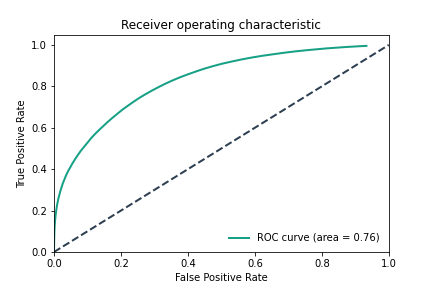

In [ ]:
evaluate(np.array(dists_dd),np.array(dists2_dd), dists_dd,thresholds_roc_start= 0.1, thresholds_roc_end=1.5,thresholds_roc_step=0.01, diagonal_excl=True)
Image.open('/content/roc.png')

#### Time execution results on Personal Photos

In [ ]:
data_dir = '/content/Faces_Folder'

Importing MTCNN.

In [ ]:
!git clone https://github.com/TreB1eN/InsightFace_Pytorch.git

fatal: destination path 'InsightFace_Pytorch' already exists and is not an empty directory.


In [ ]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [ ]:
time_ = []
aligned_dd = []
names_dd = []
trans = transforms.ToTensor()

for x, y in tqdm(loader):
  start_ = time.time()
  
  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)

    diff = time.time() - start_
    time_.append(diff)

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

  0%|          | 0/1205 [00:00<?, ?it/s]/content/InsightFace_Pytorch/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)
100%|██████████| 1205/1205 [04:48<00:00,  4.18it/s]


Total time(sec): 253.72, Average(sec):0.26, fps:3.91



Number of aligned photos after MTCNN.

In [ ]:
len(names_dd)

991

Calculating elements needed for evaluation metrices calculation.

In [ ]:
dists2_dd = [[e2==e1 for e2 in names_dd] for e1 in tqdm(names_dd)]

100%|██████████| 991/991 [00:00<00:00, 19353.97it/s]


In [ ]:
aligned_dd = torch.stack(tuple(aligned_dd)).to(device)

In [ ]:
dataset = aligned_dd.clone()
batch_size = 1

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [ ]:
data_loader.dataset.size()

torch.Size([991, 3, 112, 112])

Execution time for the model.

In [ ]:
time_ = []

lightcnn9_vA.to(device).eval()
img_transformed = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(num_output_channels=1), transforms.Resize([resize,resize]), transforms.ToTensor()])

for i, image in tqdm(enumerate(data_loader)):

  image = image.cpu()
  image = img_transformed(image.squeeze(0))
  image = image.unsqueeze(0)

  start_ = time.time()

  output = lightcnn9_vA(image.to(device))

  diff = time.time() - start_
  time_.append(diff)

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

991it [00:02, 418.09it/s]


Total time(sec): 2.28, Average(sec):0.00, fps:435.28



#### MTCNN for LFW dataset

In [ ]:
data_dir = '/content/lfw'

MTCNN importing

In [ ]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

Aligned data preparation.

In [ ]:
aligned_lfw = []
names_lfw = []
trans = transforms.ToTensor()

for x, y in tqdm(loader):
  
  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)
    aligned_lfw.append(trans(x_aligned))
    names_lfw.append(dataset.idx_to_class[y])

  0%|          | 0/13233 [00:00<?, ?it/s]/content/InsightFace_Pytorch/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)
100%|██████████| 13233/13233 [08:51<00:00, 24.92it/s]


Number of photos after MTCNN application.

In [ ]:
len(names_lfw)

13059

#### Model validation results on LWE dataset

Calculating elements for evaluation metrices calculation.

In [ ]:
labels_lfw = [[e2==e1 for e2 in names_lfw] for e1 in tqdm(names_lfw)]

100%|██████████| 13059/13059 [00:08<00:00, 1615.58it/s]


In [ ]:
len(labels_lfw)

13059

In [ ]:
aligned_lfw = torch.stack(tuple(aligned_lfw)).to(device)

In [ ]:
dataset = aligned_lfw.clone()
batch_size = 1

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [ ]:
data_loader.dataset.size()

torch.Size([13059, 3, 112, 112])

Embedding calculation.

In [ ]:
lightcnn9_vA.to(device).eval()
img_transformed = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(num_output_channels=1), transforms.Resize([resize,resize]), transforms.ToTensor()])

output_embeddings = []

for i, image in tqdm(enumerate(data_loader)):
  image = image.cpu()
  image = img_transformed(image.squeeze(0))
  image = image.unsqueeze(0)

  output = lightcnn9_vA(image.to(device))

  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

13059it [00:35, 364.46it/s]


In [ ]:
len(output_embeddings)

13059

In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
dists_lfw = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]

100%|██████████| 13059/13059 [43:06<00:00,  5.05it/s]


In [ ]:
len(dists_lfw),len(dists_lfw[0]),len(labels_lfw),len(labels_lfw[0])

(13059, 13059, 13059, 13059)

Calculating validation metrices.

the best accuracy: 0.998663100585088 True Positive rate: 0.6329009016512921 False Positive rate: 0.0003039327564919124 threshold: 0.93


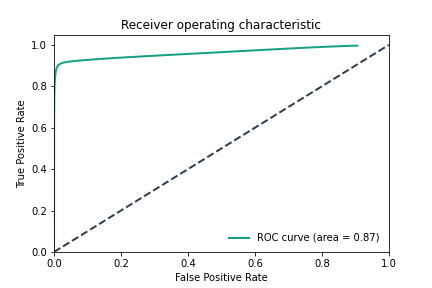

In [ ]:
evaluate(np.array(dists_lfw),np.array(labels_lfw), dists_lfw, thresholds_roc_start= 0.01, thresholds_roc_end=1.5, thresholds_roc_step=0.01, diagonal_excl=True)
Image.open('/content/roc.png')

#### Time execution results on LFW dataset

In [ ]:
time_ = []
aligned_lfw = []
names_lfw = []
trans = transforms.ToTensor()

for x, y in tqdm(loader):
  start_ = time.time()
  
  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)

    diff = time.time() - start_
    time_.append(diff)

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

  0%|          | 0/13233 [00:00<?, ?it/s]/content/InsightFace_Pytorch/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)
100%|██████████| 13233/13233 [09:14<00:00, 23.85it/s]


Total time(sec): 536.90, Average(sec):0.04, fps:24.32



In [ ]:
time_ = []

lightcnn9_vA.to(device).eval()
img_transformed = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(num_output_channels=1), transforms.Resize([resize,resize]), transforms.ToTensor()])

for i, image in tqdm(enumerate(data_loader)):

  image = image.cpu()
  image = img_transformed(image.squeeze(0))
  image = image.unsqueeze(0)

  start_ = time.time()

  output = lightcnn9_vA(image.to(device))

  diff = time.time() - start_
  time_.append(diff)

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

13059it [00:29, 445.99it/s]


Total time(sec): 18.80, Average(sec):0.00, fps:694.80



### LightCNN 9 - B

Model downlading.

In [ ]:
lightcnn9 = LightCNN_9Layers()

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1AbnUIzh_mp96MTQA4JSKjZDIMHdaCR9u'
output = 'LightCNN_9Layers_checkpoint.pth'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1AbnUIzh_mp96MTQA4JSKjZDIMHdaCR9u
To: /content/LightCNN_9Layers_checkpoint.pth
206MB [00:01, 162MB/s] 


'LightCNN_9Layers_checkpoint.pth'

In [ ]:
for name, _ in lightcnn9.named_parameters():
  print(name)

features.0.filter.weight
features.0.filter.bias
features.2.conv_a.filter.weight
features.2.conv_a.filter.bias
features.2.conv.filter.weight
features.2.conv.filter.bias
features.4.conv_a.filter.weight
features.4.conv_a.filter.bias
features.4.conv.filter.weight
features.4.conv.filter.bias
features.6.conv_a.filter.weight
features.6.conv_a.filter.bias
features.6.conv.filter.weight
features.6.conv.filter.bias
features.7.conv_a.filter.weight
features.7.conv_a.filter.bias
features.7.conv.filter.weight
features.7.conv.filter.bias
fc1.filter.weight
fc1.filter.bias
fc2.weight
fc2.bias


In [ ]:
lightcnn9

network_9layers(
  (features): Sequential(
    (0): mfm(
      (filter): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): group(
      (conv_a): mfm(
        (filter): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): group(
      (conv_a): mfm(
        (filter): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(96, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (6): group(
      (conv_a): mfm(
        (filter): Conv2d(192, 384, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (f

In [ ]:
load_dict = torch.load('/content/LightCNN_9Layers_checkpoint.pth')
state_dict = load_dict['state_dict']

In [ ]:
for name, _ in state_dict.items():
  print(name)

module.features.0.filter.weight
module.features.0.filter.bias
module.features.2.conv_a.filter.weight
module.features.2.conv_a.filter.bias
module.features.2.conv.filter.weight
module.features.2.conv.filter.bias
module.features.4.conv_a.filter.weight
module.features.4.conv_a.filter.bias
module.features.4.conv.filter.weight
module.features.4.conv.filter.bias
module.features.6.conv_a.filter.weight
module.features.6.conv_a.filter.bias
module.features.6.conv.filter.weight
module.features.6.conv.filter.bias
module.features.7.conv_a.filter.weight
module.features.7.conv_a.filter.bias
module.features.7.conv.filter.weight
module.features.7.conv.filter.bias
module.fc1.filter.weight
module.fc1.filter.bias
module.fc2.weight
module.fc2.bias


In [ ]:
new_state_dict = {}
for name, params in state_dict.items():
  new_name = name.replace('module.', '')
  new_state_dict[new_name] = params

In [ ]:
lightcnn9.load_state_dict(new_state_dict)

<All keys matched successfully>

In [ ]:
for name, params in lightcnn9.named_parameters():
  params.requires_grad = False

In [ ]:
# lightcnn9 = nn.Sequential(*list(lightcnn9.children())[:-2])
# lightcnn9

In [ ]:
lightcnn9.fc2 = nn.Linear(256, 512, bias=False)
lightcnn9

network_9layers(
  (features): Sequential(
    (0): mfm(
      (filter): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): group(
      (conv_a): mfm(
        (filter): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): group(
      (conv_a): mfm(
        (filter): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(96, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (6): group(
      (conv_a): mfm(
        (filter): Conv2d(192, 384, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (f

In [ ]:
for i, (name, prams) in enumerate(lightcnn9.named_parameters()):
  print(i, name)

0 features.0.filter.weight
1 features.0.filter.bias
2 features.2.conv_a.filter.weight
3 features.2.conv_a.filter.bias
4 features.2.conv.filter.weight
5 features.2.conv.filter.bias
6 features.4.conv_a.filter.weight
7 features.4.conv_a.filter.bias
8 features.4.conv.filter.weight
9 features.4.conv.filter.bias
10 features.6.conv_a.filter.weight
11 features.6.conv_a.filter.bias
12 features.6.conv.filter.weight
13 features.6.conv.filter.bias
14 features.7.conv_a.filter.weight
15 features.7.conv_a.filter.bias
16 features.7.conv.filter.weight
17 features.7.conv.filter.bias
18 fc1.filter.weight
19 fc1.filter.bias
20 fc2.weight


In [ ]:
for name, params in lightcnn9.named_parameters():
  if name.startswith('fc1.') or name.startswith('fc2.'):
    params.requires_grad = True
  else:
    params.requires_grad = False

for name, params in lightcnn9.named_parameters():
  if params.requires_grad == True:
    print(name)

fc1.filter.weight
fc1.filter.bias
fc2.weight


In [ ]:
resize = 120
train_data_dir = '/content/vgg2_train'
valid_data_dir = '/content/vgg2_test'

Number of identities in training and validation set.

In [ ]:
import os

def fcount(path):
    count1 = 0
    for root, dirs, files in os.walk(path):
            count1 += len(dirs)

    return print(count1)

fcount(train_data_dir) 
fcount(valid_data_dir) 

1644
411


In [ ]:
# img_transformed = Compose([Resize([resize,resize]), ToTensor()])
img_transformed = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize([resize,resize]), transforms.ToTensor()])
# img_transformed = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])



train_data = datasets.ImageFolder(train_data_dir, transform=img_transformed)
train_data.idx_to_class = {i:c for c, i in train_data.class_to_idx.items()}

valid_data = datasets.ImageFolder(valid_data_dir, transform=img_transformed)
valid_data.idx_to_class = {i:c for c, i in valid_data.class_to_idx.items()}

Model definition.

In [ ]:
class LightCNN_9(nn.Module):
    def __init__(self, net, last_layer_size, embedding_size):
        super().__init__()
        self.embedding_size = embedding_size
        self.last_layer_size = last_layer_size
        
        self.core = net
        
    def forward(self, x):
        x = self.core(x)
        x = x.view(x.shape[0],-1)
        x = torch.nn.functional.normalize(x, p=2, dim=-1)
        return x

In [ ]:
# modx = LightCNN_9(lightcnn9, 512,512)
# a = modx(torch.ones([1,1,120,120]))
# a.shape

In [ ]:
checkpoint_callback = set_checkpoint_callback('../content/gdrive/My Drive/DNN/checkpoints/', save_top_k=1, net_name='LightCNN9B')

In [ ]:
tb_logger = pl.loggers.TensorBoardLogger('../content/gdrive/My Drive/DNN/deep_metric_logs/', name='LightCNN9B')

In [ ]:
trainer = pl.Trainer(early_stop_callback=early_stop_callback, checkpoint_callback=checkpoint_callback, max_epochs=20, logger=tb_logger, gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [ ]:
lightcnn9_vB = DeepMetricLearnerB(embedding_size=512, myclass=LightCNN_9, net=lightcnn9, embedding_size_net=512, batch_size=128)

In [ ]:
for name, params in lightcnn9_vB.named_parameters():
  if params.requires_grad == True:
    print(name)

net.core.fc1.filter.weight
net.core.fc1.filter.bias
net.core.fc2.weight


Training model phase.

In [ ]:
trainer.fit(lightcnn9_vB)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name     | Type               | Params
------------------------------------------------
0 | net      | LightCNN_9         | 5 M   
1 | distance | CosineSimilarity   | 0     
2 | reducer  | ThresholdReducer   | 0     
3 | miner    | TripletMarginMiner | 0     
4 | loss     | TripletMarginLoss  | 0     
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Epoch 00000: val_loss reached 0.26479 (best 0.26479), saving model to /content/gdrive/My Drive/DNN/LightCNN9BLightCNN9B_ckpt_epoch_0.ckpt as top 1



Epoch 00001: val_loss reached 0.26303 (best 0.26303), saving model to /content/gdrive/My Drive/DNN/LightCNN9BLightCNN9B_ckpt_epoch_1.ckpt as top 1



Epoch 00002: val_loss  was not in top 1



Epoch 00003: val_loss  was not in top 1


1

Model loading from a checkpoint.

In [ ]:
lightcnn9_vB.load_from_checkpoint('/content/gdrive/My Drive/DNN/LightCNN9BLightCNN9B_ckpt_epoch_1.ckpt', myclass=LightCNN_9, net=lightcnn9)

DeepMetricLearnerB(
  (net): LightCNN_9(
    (core): network_9layers(
      (features): Sequential(
        (0): mfm(
          (filter): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        )
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
        (2): group(
          (conv_a): mfm(
            (filter): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv): mfm(
            (filter): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
        (4): group(
          (conv_a): mfm(
            (filter): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv): mfm(
            (filter): Conv2d(96, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)

In [ ]:
for names, params in lightcnn9_vB.named_parameters():
  params.requires_grad = False

for names, params in lightcnn9_vB.named_parameters():
  if params.requires_grad == True:
    print(names)

#### MTCNN for Personal Photos

In [ ]:
data_dir = '/content/Faces_Folder'

Importing MTCNN.

In [ ]:
!git clone https://github.com/TreB1eN/InsightFace_Pytorch.git

fatal: destination path 'InsightFace_Pytorch' already exists and is not an empty directory.


In [ ]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

Aligning and time execution results.

In [ ]:
aligned_dd = []
names_dd = []
time_ = []

trans = transforms.ToTensor()

for x, y in tqdm(loader):

  start_ = time.time()

  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)

    diff = time.time() - start_
    time_.append(diff)

    aligned_dd.append(trans(x_aligned))
    names_dd.append(dataset.idx_to_class[y])

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

  0%|          | 0/1205 [00:00<?, ?it/s]/content/InsightFace_Pytorch/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)
100%|██████████| 1205/1205 [04:24<00:00,  4.56it/s]


Total time(sec): 231.33, Average(sec):0.23, fps:4.28



Number of aligned photos after MTCNN.

In [ ]:
len(names_dd)

991

#### Model validation results on Personal Photos

Calculating elements needed for evaluation metrices calculation.

In [ ]:
dists2_dd = [[e2==e1 for e2 in names_dd] for e1 in tqdm(names_dd)]

100%|██████████| 991/991 [00:00<00:00, 23246.43it/s]


In [ ]:
aligned_dd = torch.stack(tuple(aligned_dd)).to(device)

In [ ]:
dataset = aligned_dd.clone()
batch_size = 1

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [ ]:
data_loader.dataset.size()

torch.Size([991, 3, 112, 112])

In [ ]:
time_ = []

lightcnn9_vB.to(device).eval()
img_transformed = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(num_output_channels=1), transforms.Resize([resize,resize]), transforms.ToTensor()])

output_embeddings = []

for i, image in tqdm(enumerate(data_loader)):
  start_ = time.time()

  image = image.cpu()
  image = img_transformed(image.squeeze(0))
  image = image.unsqueeze(0)

  output = lightcnn9_vB(image.to(device))

  diff = time.time() - start_
  time_.append(diff)

  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

991it [00:02, 417.68it/s]


Total time(sec): 2.10, Average(sec):0.00, fps:471.08



In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
len(output_embeddings)

991

In [ ]:
dists_dd = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]

100%|██████████| 991/991 [00:12<00:00, 76.40it/s]


In [ ]:
len(dists_dd),len(dists_dd[0]),len(dists2_dd),len(dists2_dd[0])

(991, 991, 991, 991)

In [ ]:
np.array(dists_dd)[0].size

991

the best accuracy: 0.8279790844876617 True Positive rate: 0.5852598512612516 False Positive rate: 0.05612447742852668 threshold: 1.2399999999999995


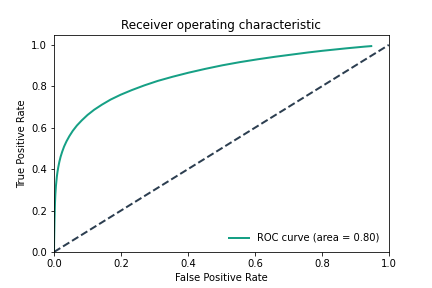

In [ ]:
evaluate(np.array(dists_dd),np.array(dists2_dd), dists_dd,thresholds_roc_start= 0.1, thresholds_roc_end=1.5,thresholds_roc_step=0.01, diagonal_excl=True)
Image.open('/content/roc.png')

#### MTCNN for LFW dataset

In [ ]:
data_dir = '/content/lfw'

MTCNN importing

In [ ]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

Aligned data preparation and time execution.

In [ ]:
time_ = []
aligned_lfw = []
names_lfw = []

trans = transforms.ToTensor()

for x, y in tqdm(loader):
  
  start_ = time.time()

  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)

    diff = time.time() - start_
    time_.append(diff)

    aligned_lfw.append(trans(x_aligned))
    names_lfw.append(dataset.idx_to_class[y])


# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
100%|██████████| 13233/13233 [11:30<00:00, 19.15it/s]


Total time(sec): 644.47, Average(sec):0.05, fps:20.26



Number of photos after MTCNN application.

In [ ]:
len(names_lfw)

13059

#### Model validation results on LWE dataset

Calculating elements for evaluation metrices calculation.

In [ ]:
labels_lfw = [[e2==e1 for e2 in names_lfw] for e1 in tqdm(names_lfw)]


100%|██████████| 13059/13059 [00:07<00:00, 1636.43it/s]


In [ ]:
len(labels_lfw)

13059

In [ ]:
aligned_lfw = torch.stack(tuple(aligned_lfw)).to(device)

In [ ]:
dataset = aligned_lfw.clone()
batch_size = 1

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [ ]:
data_loader.dataset.size()

torch.Size([13059, 3, 112, 112])

Embedding calculation.

In [ ]:
time_ = []

lightcnn9_vB.to(device).eval()
img_transformed = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(num_output_channels=1), transforms.Resize([resize,resize]), transforms.ToTensor()])

output_embeddings = []

for i, image in tqdm(enumerate(data_loader)):
  image = image.cpu()
  image = img_transformed(image.squeeze(0))
  image = image.unsqueeze(0)

  start_ = time.time()

  output = lightcnn9_vB(image.to(device))

  diff = time.time() - start_
  time_.append(diff)

  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))


0it [00:00, ?it/s]
38it [00:00, 378.86it/s]
75it [00:00, 373.97it/s]
114it [00:00, 377.29it/s]
154it [00:00, 383.06it/s]
193it [00:00, 383.09it/s]
234it [00:00, 389.73it/s]
274it [00:00, 392.61it/s]
315it [00:00, 394.46it/s]
354it [00:00, 391.70it/s]
394it [00:01, 391.87it/s]
433it [00:01, 390.28it/s]
473it [00:01, 390.91it/s]
512it [00:01, 378.29it/s]
552it [00:01, 382.03it/s]
591it [00:01, 384.30it/s]
631it [00:01, 388.14it/s]
672it [00:01, 392.24it/s]
712it [00:01, 391.53it/s]
752it [00:01, 388.90it/s]
793it [00:02, 392.71it/s]
835it [00:02, 398.14it/s]
875it [00:02, 390.55it/s]
915it [00:02, 391.14it/s]
955it [00:02, 393.08it/s]
996it [00:02, 396.63it/s]
1037it [00:02, 400.54it/s]
1079it [00:02, 404.46it/s]
1121it [00:02, 406.57it/s]
1162it [00:02, 400.58it/s]
1203it [00:03, 393.33it/s]
1244it [00:03, 397.26it/s]
1285it [00:03, 398.25it/s]
1325it [00:03, 392.13it/s]
1365it [00:03, 384.24it/s]
1405it [00:03, 388.21it/s]
1446it [00:03, 393.17it/s]
1488it [00:03, 399.63it/s]
1529it [


Total time(sec): 19.09, Average(sec):0.00, fps:684.00



In [ ]:
len(output_embeddings)

13059

In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
dists_lfw = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]

100%|██████████| 13059/13059 [38:35<00:00,  5.64it/s]


In [ ]:
len(dists_lfw),len(dists_lfw[0]),len(labels_lfw),len(labels_lfw[0])

(13059, 13059, 13059, 13059)

Calculating validation metrices.

the best accuracy: 0.9993035601668833 True Positive rate: 0.8034400183245528 False Positive rate: 0.0001432921625456046 threshold: 1.06


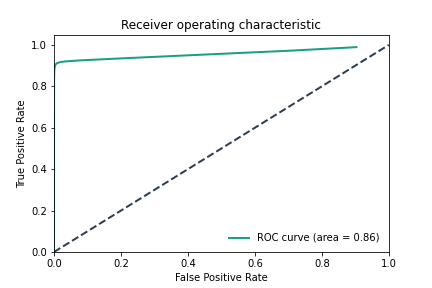

In [ ]:
evaluate(np.array(dists_lfw),np.array(labels_lfw), dists_lfw, thresholds_roc_start= 0.01, thresholds_roc_end=1.5, thresholds_roc_step=0.01, diagonal_excl=True)
Image.open('/content/roc.png')

### LightCNN 9 - C

Model downlading.

In [ ]:
lightcnn9 = LightCNN_9Layers()

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1AbnUIzh_mp96MTQA4JSKjZDIMHdaCR9u'
output = 'LightCNN_9Layers_checkpoint.pth'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1AbnUIzh_mp96MTQA4JSKjZDIMHdaCR9u
To: /content/LightCNN_9Layers_checkpoint.pth
206MB [00:01, 121MB/s]


'LightCNN_9Layers_checkpoint.pth'

In [ ]:
for name, _ in lightcnn9.named_parameters():
  print(name)

features.0.filter.weight
features.0.filter.bias
features.2.conv_a.filter.weight
features.2.conv_a.filter.bias
features.2.conv.filter.weight
features.2.conv.filter.bias
features.4.conv_a.filter.weight
features.4.conv_a.filter.bias
features.4.conv.filter.weight
features.4.conv.filter.bias
features.6.conv_a.filter.weight
features.6.conv_a.filter.bias
features.6.conv.filter.weight
features.6.conv.filter.bias
features.7.conv_a.filter.weight
features.7.conv_a.filter.bias
features.7.conv.filter.weight
features.7.conv.filter.bias
fc1.filter.weight
fc1.filter.bias
fc2.weight
fc2.bias


In [ ]:
lightcnn9

network_9layers(
  (features): Sequential(
    (0): mfm(
      (filter): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): group(
      (conv_a): mfm(
        (filter): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): group(
      (conv_a): mfm(
        (filter): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(96, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (6): group(
      (conv_a): mfm(
        (filter): Conv2d(192, 384, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (f

In [ ]:
load_dict = torch.load('/content/LightCNN_9Layers_checkpoint.pth')
state_dict = load_dict['state_dict']

In [ ]:
for name, _ in state_dict.items():
  print(name)

module.features.0.filter.weight
module.features.0.filter.bias
module.features.2.conv_a.filter.weight
module.features.2.conv_a.filter.bias
module.features.2.conv.filter.weight
module.features.2.conv.filter.bias
module.features.4.conv_a.filter.weight
module.features.4.conv_a.filter.bias
module.features.4.conv.filter.weight
module.features.4.conv.filter.bias
module.features.6.conv_a.filter.weight
module.features.6.conv_a.filter.bias
module.features.6.conv.filter.weight
module.features.6.conv.filter.bias
module.features.7.conv_a.filter.weight
module.features.7.conv_a.filter.bias
module.features.7.conv.filter.weight
module.features.7.conv.filter.bias
module.fc1.filter.weight
module.fc1.filter.bias
module.fc2.weight
module.fc2.bias


In [ ]:
new_state_dict = {}
for name, params in state_dict.items():
  new_name = name.replace('module.', '')
  new_state_dict[new_name] = params

In [ ]:
lightcnn9.load_state_dict(new_state_dict)

<All keys matched successfully>

In [ ]:
for name, params in lightcnn9.named_parameters():
  params.requires_grad = False

In [ ]:
# lightcnn9 = nn.Sequential(*list(lightcnn9.children())[:-2])
# lightcnn9

In [ ]:
lightcnn9.fc2 = nn.Linear(256, 512, bias=False)
lightcnn9

network_9layers(
  (features): Sequential(
    (0): mfm(
      (filter): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): group(
      (conv_a): mfm(
        (filter): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): group(
      (conv_a): mfm(
        (filter): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(96, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (6): group(
      (conv_a): mfm(
        (filter): Conv2d(192, 384, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (f

In [ ]:
for i, (name, prams) in enumerate(lightcnn9.named_parameters()):
  print(i, name)

0 features.0.filter.weight
1 features.0.filter.bias
2 features.2.conv_a.filter.weight
3 features.2.conv_a.filter.bias
4 features.2.conv.filter.weight
5 features.2.conv.filter.bias
6 features.4.conv_a.filter.weight
7 features.4.conv_a.filter.bias
8 features.4.conv.filter.weight
9 features.4.conv.filter.bias
10 features.6.conv_a.filter.weight
11 features.6.conv_a.filter.bias
12 features.6.conv.filter.weight
13 features.6.conv.filter.bias
14 features.7.conv_a.filter.weight
15 features.7.conv_a.filter.bias
16 features.7.conv.filter.weight
17 features.7.conv.filter.bias
18 fc1.filter.weight
19 fc1.filter.bias
20 fc2.weight


In [ ]:
for name, params in lightcnn9.named_parameters():
  if name.startswith('fc1.') or name.startswith('fc2.'):
    params.requires_grad = True
  else:
    params.requires_grad = False

for name, params in lightcnn9.named_parameters():
  if params.requires_grad == True:
    print(name)

fc1.filter.weight
fc1.filter.bias
fc2.weight


In [ ]:
resize = 120
train_data_dir = '/content/vgg2_train'
valid_data_dir = '/content/vgg2_test'

Number of identities in training and validation set.

In [ ]:
import os

def fcount(path):
    count1 = 0
    for root, dirs, files in os.walk(path):
            count1 += len(dirs)

    return print(count1)

fcount(train_data_dir) 
fcount(valid_data_dir) 

1644
411


In [ ]:
# img_transformed = Compose([Resize([resize,resize]), ToTensor()])
img_transformed = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize([resize,resize]), transforms.ToTensor()])
# img_transformed = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])



train_data = datasets.ImageFolder(train_data_dir, transform=img_transformed)
train_data.idx_to_class = {i:c for c, i in train_data.class_to_idx.items()}

valid_data = datasets.ImageFolder(valid_data_dir, transform=img_transformed)
valid_data.idx_to_class = {i:c for c, i in valid_data.class_to_idx.items()}

Model definition.

In [ ]:
class LightCNN_9(nn.Module):
    def __init__(self, net, last_layer_size, embedding_size):
        super().__init__()
        self.embedding_size = embedding_size
        self.last_layer_size = last_layer_size
        
        self.core = net
        
    def forward(self, x):
        x = self.core(x)
        x = x.view(x.shape[0],-1)
        x = torch.nn.functional.normalize(x, p=2, dim=-1)
        return x

In [ ]:
# modx = LightCNN_9(lightcnn9, 512,512)
# a = modx(torch.ones([1,1,120,120]))
# a.shape

In [ ]:
checkpoint_callback = set_checkpoint_callback('../content/gdrive/My Drive/DNN/checkpoints/', save_top_k=1, net_name='LightCNN9C')

In [ ]:
tb_logger = pl.loggers.TensorBoardLogger('../content/gdrive/My Drive/DNN/deep_metric_logs/', name='LightCNN9C')

In [ ]:
trainer = pl.Trainer(early_stop_callback=early_stop_callback, checkpoint_callback=checkpoint_callback, max_epochs=20, logger=tb_logger, gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [ ]:
lightcnn9_vC = DeepMetricLearnerC(embedding_size=512, myclass=LightCNN_9, net=lightcnn9, embedding_size_net=512, batch_size=128)

In [ ]:
for name, params in lightcnn9_vC.named_parameters():
  if params.requires_grad == True:
    print(name)

net.core.fc1.filter.weight
net.core.fc1.filter.bias
net.core.fc2.weight


Training model phase.

In [ ]:
trainer.fit(lightcnn9_vC)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type                           | Params
---------------------------------------------------------
0 | net   | LightCNN_9                     | 5 M   
1 | miner | BatchHardMiner                 | 0     
2 | loss  | GeneralizedLiftedStructureLoss | 0     
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Epoch 00000: val_loss reached 0.89218 (best 0.89218), saving model to /content/gdrive/My Drive/DNN/LightCNN9CLightCNN9C_ckpt_epoch_0.ckpt as top 1



Epoch 00001: val_loss  was not in top 1



Epoch 00002: val_loss reached 0.89092 (best 0.89092), saving model to /content/gdrive/My Drive/DNN/LightCNN9CLightCNN9C_ckpt_epoch_2.ckpt as top 1



Epoch 00003: val_loss  was not in top 1



Epoch 00004: val_loss  was not in top 1
Saving latest checkpoint..


1

Model loading from a checkpoint.

In [ ]:
lightcnn9_vC.load_from_checkpoint('/content/gdrive/My Drive/DNN/LightCNN9CLightCNN9C_ckpt_epoch_2.ckpt', myclass=LightCNN_9, net=lightcnn9)

DeepMetricLearnerC(
  (net): LightCNN_9(
    (core): network_9layers(
      (features): Sequential(
        (0): mfm(
          (filter): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        )
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
        (2): group(
          (conv_a): mfm(
            (filter): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv): mfm(
            (filter): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
        (4): group(
          (conv_a): mfm(
            (filter): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv): mfm(
            (filter): Conv2d(96, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)

In [ ]:
for names, params in lightcnn9_vC.named_parameters():
  params.requires_grad = False

for names, params in lightcnn9_vC.named_parameters():
  if params.requires_grad == True:
    print(names)

#### MTCNN for Personal Photos

In [ ]:
data_dir = '/content/Faces_Folder'

Importing MTCNN.

In [ ]:
!git clone https://github.com/TreB1eN/InsightFace_Pytorch.git

fatal: destination path 'InsightFace_Pytorch' already exists and is not an empty directory.


In [ ]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

Data alignmet and time execution results.

In [ ]:
time_ = []

aligned_dd = []
names_dd = []
trans = transforms.ToTensor()

for x, y in tqdm(loader):

  start_ = time.time()

  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)

    diff = time.time() - start_
    time_.append(diff)

    aligned_dd.append(trans(x_aligned))
    names_dd.append(dataset.idx_to_class[y])


# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

  0%|          | 0/1205 [00:00<?, ?it/s]/content/InsightFace_Pytorch/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)
100%|██████████| 1205/1205 [04:35<00:00,  4.37it/s]


Total time(sec): 241.71, Average(sec):0.24, fps:4.10



Number of aligned photos after MTCNN.

In [ ]:
len(names_dd)

991

#### Model validation results on Personal Photos

Calculating elements needed for evaluation metrices calculation.

In [ ]:
dists2_dd = [[e2==e1 for e2 in names_dd] for e1 in tqdm(names_dd)]

100%|██████████| 991/991 [00:00<00:00, 20682.98it/s]


In [ ]:
aligned_dd = torch.stack(tuple(aligned_dd)).to(device)

In [ ]:
dataset = aligned_dd.clone()
batch_size = 1

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [ ]:
data_loader.dataset.size()

torch.Size([991, 3, 112, 112])

In [ ]:
time_ = []

lightcnn9_vC.to(device).eval()
img_transformed = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(num_output_channels=1), transforms.Resize([resize,resize]), transforms.ToTensor()])

output_embeddings = []

for i, image in tqdm(enumerate(data_loader)):
  image = image.cpu()
  image = img_transformed(image.squeeze(0))
  image = image.unsqueeze(0)

  start_ = time.time()

  output = lightcnn9_vC(image.to(device))

  diff = time.time() - start_
  time_.append(diff)

  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))



991it [00:02, 382.25it/s]


Total time(sec): 1.53, Average(sec):0.00, fps:647.72



In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
len(output_embeddings)

991

In [ ]:
dists_dd = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]

100%|██████████| 991/991 [00:16<00:00, 60.75it/s]


In [ ]:
len(dists_dd),len(dists_dd[0]),len(dists2_dd),len(dists2_dd[0])

(991, 991, 991, 991)

In [ ]:
np.array(dists_dd)[0].size

991

the best accuracy: 0.8324944704359437 True Positive rate: 0.6070029583745971 False Positive rate: 0.05983518667999952 threshold: 1.2499999999999996


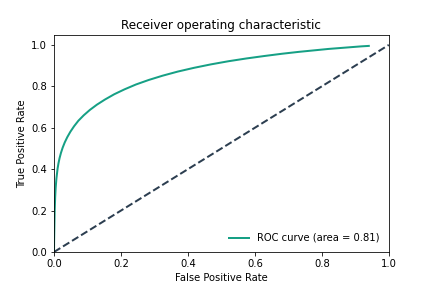

In [ ]:
evaluate(np.array(dists_dd),np.array(dists2_dd), dists_dd,thresholds_roc_start= 0.1, thresholds_roc_end=1.5,thresholds_roc_step=0.01, diagonal_excl=True)
Image.open('/content/roc.png')

#### MTCNN for LFW dataset

In [ ]:
data_dir = '/content/lfw'

MTCNN importing

In [ ]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

Aligned data preparation and execution time results.

In [ ]:
time_ = []

aligned_lfw = []
names_lfw = []
trans = transforms.ToTensor()

for x, y in tqdm(loader):

  start_ = time.time()

  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)

    diff = time.time() - start_
    time_.append(diff)

    aligned_lfw.append(trans(x_aligned))
    names_lfw.append(dataset.idx_to_class[y])

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

  0%|          | 0/13233 [00:00<?, ?it/s]/content/InsightFace_Pytorch/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)
100%|██████████| 13233/13233 [09:25<00:00, 23.41it/s]


Total time(sec): 539.35, Average(sec):0.04, fps:24.21



Number of photos after MTCNN application.

In [ ]:
len(names_lfw)

13059

#### Model validation results on LWE dataset

Calculating elements for evaluation metrices calculation.

In [ ]:
labels_lfw = [[e2==e1 for e2 in names_lfw] for e1 in tqdm(names_lfw)]

100%|██████████| 13059/13059 [00:08<00:00, 1551.32it/s]


In [ ]:
len(labels_lfw)

13059

In [ ]:
aligned_lfw = torch.stack(tuple(aligned_lfw)).to(device)

In [ ]:
dataset = aligned_lfw.clone()
batch_size = 1

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [ ]:
data_loader.dataset.size()

torch.Size([13059, 3, 112, 112])

Embedding calculation.

In [ ]:
time_ = []

lightcnn9_vC.to(device).eval()
img_transformed = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(num_output_channels=1), transforms.Resize([resize,resize]), transforms.ToTensor()])

output_embeddings = []

for i, image in tqdm(enumerate(data_loader)):
  image = image.cpu()
  image = img_transformed(image.squeeze(0))
  image = image.unsqueeze(0)

  start_ = time.time()

  output = lightcnn9_vC(image.to(device))

  diff = time.time() - start_
  time_.append(diff)

  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

13059it [00:34, 378.67it/s]


Total time(sec): 20.44, Average(sec):0.00, fps:638.74



In [ ]:
len(output_embeddings)

13059

In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
dists_lfw = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]

100%|██████████| 13059/13059 [46:39<00:00,  4.66it/s]


In [ ]:
len(dists_lfw),len(dists_lfw[0]),len(labels_lfw),len(labels_lfw[0])

(13059, 13059, 13059, 13059)

Calculating validation metrices.

the best accuracy: 0.9993403877363678 True Positive rate: 0.8155092351581534 False Positive rate: 0.00014044584363104857 threshold: 1.06


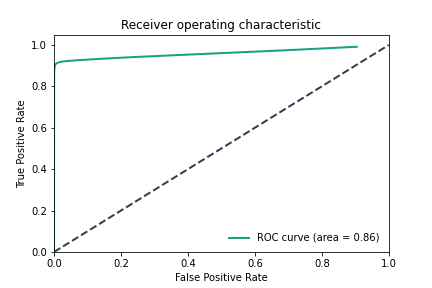

In [ ]:
evaluate(np.array(dists_lfw),np.array(labels_lfw), dists_lfw, thresholds_roc_start= 0.01, thresholds_roc_end=1.5, thresholds_roc_step=0.01, diagonal_excl=True)
Image.open('/content/roc.png')